# Volumetric searchlight hyperalignment, 4th part

<br><br>
<font size="4">

Here we do the cross-validation again, but withh the better prprocessed data we also used for part 3. We slice our data into ten parts and for each part, we train the hyperalignment on the rest (nine tenth) of the data and test the effects of hyperalingment in terms of ISC on the held-out (on tenth) dataset. We expect to see a marked effect of hyperalignment.

We use the 8-subjects dataset as in part 3, already arranged in pymvpa dataset format.
</font>
<br>

## 1. Basics: imports, loading data
<br>

In [1]:
from __future__ import division
from mvpa2.suite import *
import numpy as np
import time
import gc
from matplotlib import pyplot
from matplotlib import rcParams
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from functools import reduce

/usr/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/lib/python2.7/dist-packages/mvpa2/testing/tools.py:81: DeprecationWarning: Importing from numpy.testing.decorators is deprecated since numpy 1.15.0, import from numpy.testing instead.
  from numpy.testing.decorators import skipif
/usr/lib/python2.7/dist-packages/_pytest/fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
/usr/lib/python2.7/dist-packages/_pytest/fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_i

In [2]:
folderPath = '/home/adamb/PycharmProjects/preproc/runs34_files/'
datasetName = 'hyperDataset.hdf5'
ds = h5load(folderPath+datasetName)

/home/adamb/.local/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


<br>
<font size="4">
Then create a sampling attribute for chunking the data into ten parts. Each chunk covers 95-95 consecutive volumes except for the last, 10th chunk with 91 volumes. 
</font>
<br><br>

In [4]:
# we define 10 chunks for our 946 volumes (samples),
# with chunks no. 1-9 covering 95-95 volumes and chunk no. 10 covering the last 91

# basic variables: 
# no. of subjects, no. of samples, no. of chunks, length of one chunk in volumes
subNo = len(ds)
sampleNo = len(ds[0])
chunkNo = 10
chunkLength = int(np.ceil(sampleNo/chunkNo))

# create an array indexing each volume with the right chunk 
chunks = np.ones([chunkNo*chunkLength,])
for z in range(chunkNo):
    chunks[z*chunkLength:(z+1)*chunkLength] = chunks[z*chunkLength:(z+1)*chunkLength]*z
chunks = chunks[:sampleNo]
    
# add chunks as a sample attribute to each dataset
for subIdx in range(subNo):
    ds[subIdx].sa['chunks'] = chunks
    ds[subIdx].sa.chunks = chunks
    zscore(ds[subIdx], chunks_attr='chunks')  # zscore for each chunk separately
#    ds[subIdx].sa.chunks = chunks

## zscore for each chunk separately
#for data in range(subNo):
#    ds[data].sa['chunks'] = chunks
#    zscore(ds[data], chunks_attr='chunks')
    

## 2. Ten-fold validation of hyperalignment using ISC

<br>
<font size="4">
Next, in each run we leave one chunk out of the volumetric searchlight hyperalignment procedure and test the hyperalignment effects on that chunk by running ISC with leave-on-out group means. 
</font>
<br><br>

<div class="alert alert-block alert-warning">
    <font size ="4">
    <b>Might take hours on a laptop!</b>
    </font>
</div>

In [5]:
# no. of voxels we have not defined yet
featureNo = ds[0].shape[1]

# initializing results matrices
meanCorr = np.empty([chunkNo, featureNo])  # for correlation coeffs without hyperalignment
meanCorrHyper = np.empty([chunkNo, featureNo])  # with hyperalignment

validationStart = time.time()

# loop through the runs / chunks
for chunk in range(chunkNo):
# for chunk in [1]:
    
    chunkStart = time.time()
    print '\n\n Started run ' + str(chunk) + '...\n'
    
    # hackish solution for variable chunkLength (due to last run having different number of volumes)
    chunkLength = sum(chunks==chunk)
    
    # separate datasets for hyperalignment and for ISC (training and testing)
    dsHyper = [subDS[subDS.sa.chunks != chunk, :] for subDS in ds]
    dsISC = [subDS[subDS.sa.chunks == chunk, :] for subDS in ds]
    
    # before calling hyperalignment, get correlation coeffs for the "raw" chunk data:
    
    # result matrix for storing correlation coeffs: subjects X voxels (==features)
    corrRes = np.empty([subNo, featureNo])
    # we extract the group data into one np array from the datasets so we can calculate with it more easily
    groupData = np.empty([subNo, chunkLength, featureNo])
    for subIdx in range(subNo):
        groupData[subIdx, :, :] = dsISC[subIdx].__array__()       
    # go through subjects, correlate with the rest of the group
    for subIdx in range(subNo):
        # indices for everyone except the main subject in the loop
        groupIndices = list(range(subNo))
        del(groupIndices[subIdx])
        # mean data for everyone except our subject of interest
        groupMean = np.mean(groupData[groupIndices, :, :], 0)
        # loop through voxels (features)
        for feature in range(featureNo):
            # it is inefficient this way, should use stg like np.dot() with vector magnitude normalization
            # e.g. np.dot(a,b)/(np.sqrt(a.dot(a))*np.sqrt(b.dot(b))) ???
            corrRes[subIdx, feature] = np.corrcoef(dsISC[subIdx].__array__()[:, feature], groupMean[:, feature], rowvar=False)[0, 1]
    # mean correlation map for given chunk
    meanCorr[chunk, :] = np.mean(corrRes, 0)  
    corrEnd = time.time()
    print 'Correlations on raw test data in run ' + str(chunk) + ' took ' + str(corrEnd-chunkStart) + ' secs'     
    
    
    # hyperalignment part
    
    # we call SearchlightHyperalignment mostly with default values: 
    # each sphere has a radius of 3 voxels, sphere centers are also 3 voxels apart, 
    # all voxels in a given sphere are used for alignment
    slhyper = SearchlightHyperalignment(radius=3, 
                                    sparse_radius=3, 
                                    nproc=1)

    # call the hyperalignment object with the training dataset
    slhypermaps = slhyper(dsHyper)
    hyperEnd = time.time()
    print 'Hyperalignment in run ' + str(chunk) + ' took ' + str(hyperEnd-corrEnd) + ' secs'
    
    # apply the hyperalignment mappers to the ISC (test data)
    dsISC_hyper = [m.forward(s) for m, s in zip(slhypermaps, dsISC)]
    projectionEnd = time.time()
    print 'Projections to common space in run ' + str(chunk) + ' took ' + str(projectionEnd-hyperEnd) + ' secs'
    
    # save out the mappings from each run
    saveFile = 'run' + str(chunk) + '_hypermaps.hdf5'
    h5save(saveFile, slhypermaps)
    
    # free some memory
    del slhypermaps
    gc.collect()
    
    # calculate ISC on the test data projected into common space
    
    # result matrix for storing correlation coeffs: subjects X voxels (==features)
    corrResHyper = np.empty([subNo, featureNo])
    # we extract the group data into one np array from the datasets so we can calculate with it more easily
    groupData = np.empty([subNo, chunkLength, featureNo])
    for subIdx in range(subNo):
        groupData[subIdx, :, :] = dsISC_hyper[subIdx].__array__()       
    # go through subjects, correlate with the rest of the group
    for subIdx in range(subNo):
        # indices for everyone except the main subject in the loop
        groupIndices = list(range(subNo))
        del(groupIndices[subIdx])
        # mean data for everyone except our subject of interest
        groupMean = np.mean(groupData[groupIndices, :, :], 0)
        # loop through voxels (features)
        for feature in range(featureNo):
            # it is inefficient this way, should use stg like np.dot() with vector magnitude normalization
            # e.g. np.dot(a,b)/(np.sqrt(a.dot(a))*np.sqrt(b.dot(b))) ???
            corrResHyper[subIdx, feature] = np.corrcoef(dsISC_hyper[subIdx].__array__()[:, feature], groupMean[:, feature], rowvar=False)[0, 1]
    # mean correlation map for given chunk
    meanCorrHyper[chunk, :] = np.mean(corrResHyper, 0)            
    print 'Correlations on test data in run ' + str(chunk) + ' took ' + str(time.time()-projectionEnd) + ' secs'
    
    # free memory
    del dsHyper
    del dsISC
    gc.collect()
    
    # end of run progress report
    print '\nRun ' + str(chunk) + ' took ' + str(time.time()-chunkStart) + ' secs'
    print '\n' + str(time.time()-validationStart) + ' secs elapsed since starting the validation procedure\n'




 Started run 0...

Correlations on raw test data in run 0 took 32.8124890327 secs
 * Please note: warnings are printed only once, but underlying problem might occur many times *
Hyperalignment in run 0 took 2018.77850199 secs
Projections to common space in run 0 took 8.38604807854 secs
Correlations on test data in run 0 took 53.7912480831 secs

Run 0 took 2113.92929411 secs

2113.930089 secs elapsed since starting the validation procedure



 Started run 1...

Correlations on raw test data in run 1 took 31.3043189049 secs
Hyperalignment in run 1 took 1971.68919802 secs
Projections to common space in run 1 took 8.42735004425 secs
Correlations on test data in run 1 took 53.8636000156 secs

Run 1 took 2065.44583702 secs

4179.37630606 secs elapsed since starting the validation procedure



 Started run 2...

Correlations on raw test data in run 2 took 30.7649381161 secs
Hyperalignment in run 2 took 1949.42451596 secs
Projections to common space in run 2 took 8.44129800797 secs
Correlati

In [6]:
# save out the results of the above cell
h5save('hyperValidation_baseCorrValues.hdf5', meanCorr)
h5save('hyperValidation_testCorrValues.hdf5', meanCorrHyper)

## 3. Check the results

<br>
<font size="4">
We plot the histograms of the correlation values both for the non-hyperalinged and the hyperaligned data, averaged across the ten runs. Also look at some descriptives.
</font>
<br><br>

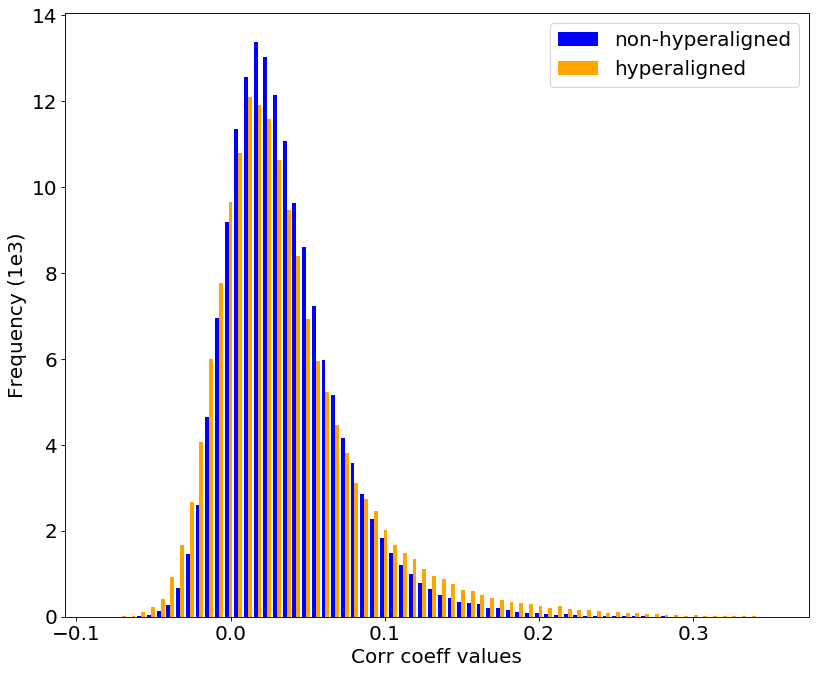


Descriptives for ISC results on Non-hyperaligned data: 

Number of voxels with corr coeff > 0.1: 3757
Number of voxels with corr coeff > 0.2: 157
Number of voxels with corr coeff > 0.3: 2
Mean: 0.03478790559482216
Median: 0.02849477679468413

Descriptives for ISC results on Hyperaligned data: 

Number of voxels with corr coeff > 0.1: 6190
Number of voxels with corr coeff > 0.2: 841
Number of voxels with corr coeff > 0.3: 60
Mean: 0.0366862349886989
Median: 0.02670243636433431

Number of voxels with larger corr coeff values after hyperalignment: 34277

Number of voxels with smaller corr coeff values after hyperalignment: 33366


In [7]:
# mean corr values, across all 10 runs/chunks
rawMeans = np.nanmean(meanCorr, axis=0)
hyperMeans = np.mean(meanCorrHyper, axis=0)

# histogram with the two datasets

# size settings
fig = pyplot.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
rcParams.update({'font.size': 18})

# histogram details
colors = ['blue', 'orange']
labels = ['non-hyperaligned', 'hyperaligned']
nbins = 70

pyplot.hist([rawMeans, hyperMeans], 
                nbins, 
                density=True, 
                color=colors,
                label=labels)
pyplot.xlabel('Corr coeff values')
pyplot.ylabel('Frequency (1e3)')
pyplot.legend(loc='best')
pyplot.show()

# descriptives
print '\nDescriptives for ISC results on Non-hyperaligned data: \n'
print 'Number of voxels with corr coeff > 0.1: ' + str(sum(rawMeans>0.1))
print 'Number of voxels with corr coeff > 0.2: ' + str(sum(rawMeans>0.2))
print 'Number of voxels with corr coeff > 0.3: ' + str(sum(rawMeans>0.3))
print 'Mean: ' + str(np.mean(rawMeans))
print 'Median: ' + str(np.median(rawMeans))

print '\nDescriptives for ISC results on Hyperaligned data: \n'
print 'Number of voxels with corr coeff > 0.1: ' + str(sum(hyperMeans>0.1))
print 'Number of voxels with corr coeff > 0.2: ' + str(sum(hyperMeans>0.2))
print 'Number of voxels with corr coeff > 0.3: ' + str(sum(hyperMeans>0.3))
print 'Mean: ' + str(np.mean(hyperMeans))
print 'Median: ' + str(np.median(hyperMeans))

print '\nNumber of voxels with larger corr coeff values after hyperalignment: ' + str(sum(hyperMeans>rawMeans))

print '\nNumber of voxels with smaller corr coeff values after hyperalignment: ' + str(sum(hyperMeans<rawMeans))


<br>
<font size="4">
<b>Much nicer than last time</b>
<br>
Heavier positive tail! 
    
Let's also look at the results from individual chunks/runs, perhaps they give a clue to what's going on.

</font>
<br><br>



Chunk/run 0



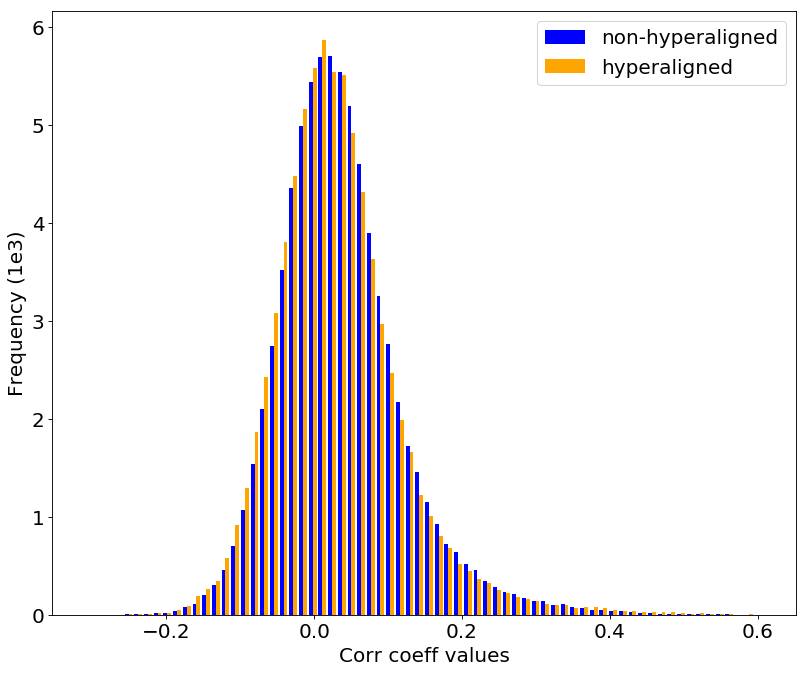



Chunk/run 1



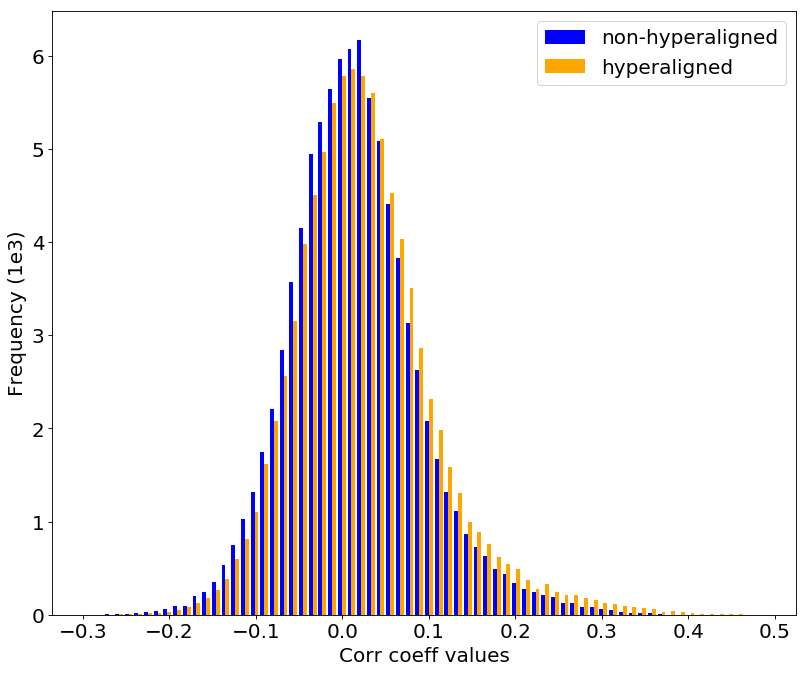



Chunk/run 2



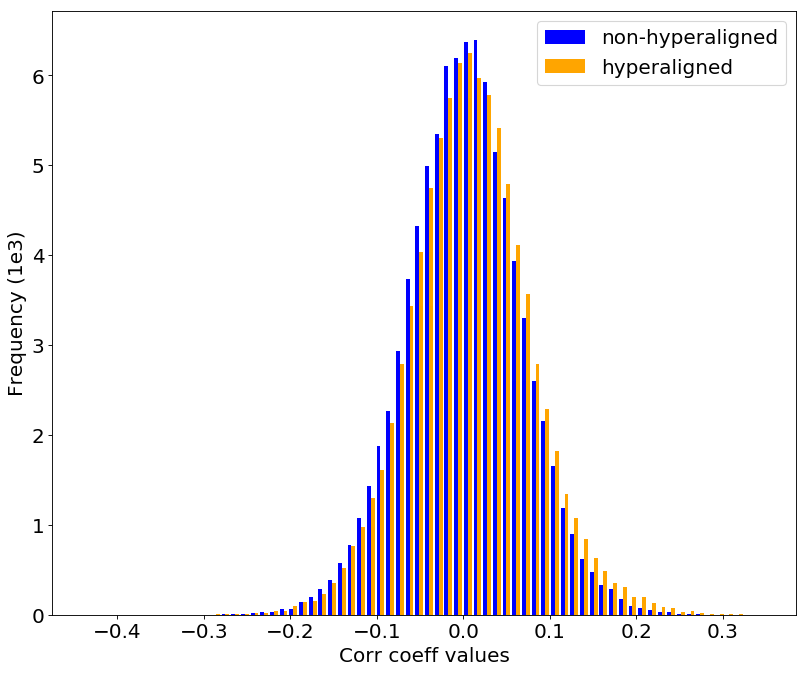



Chunk/run 3



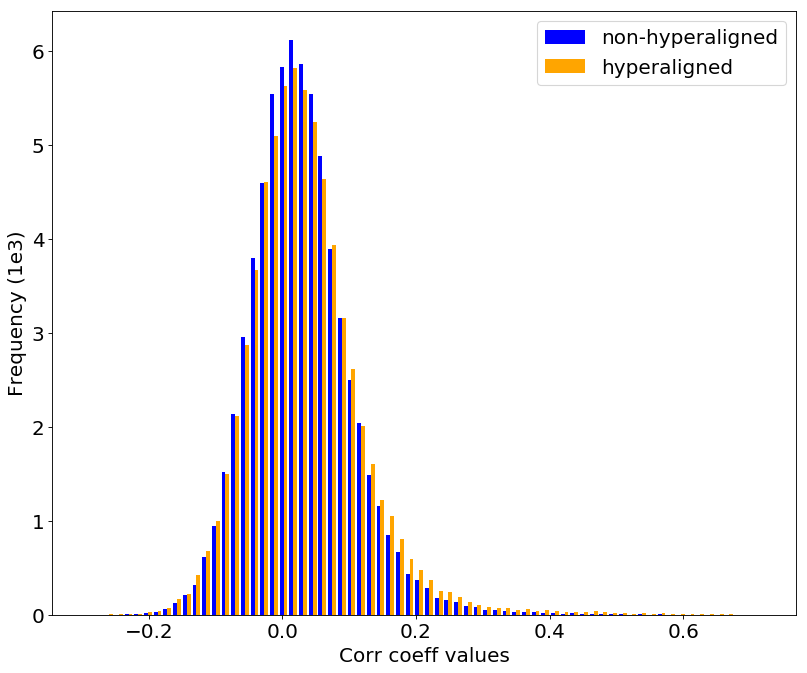



Chunk/run 4



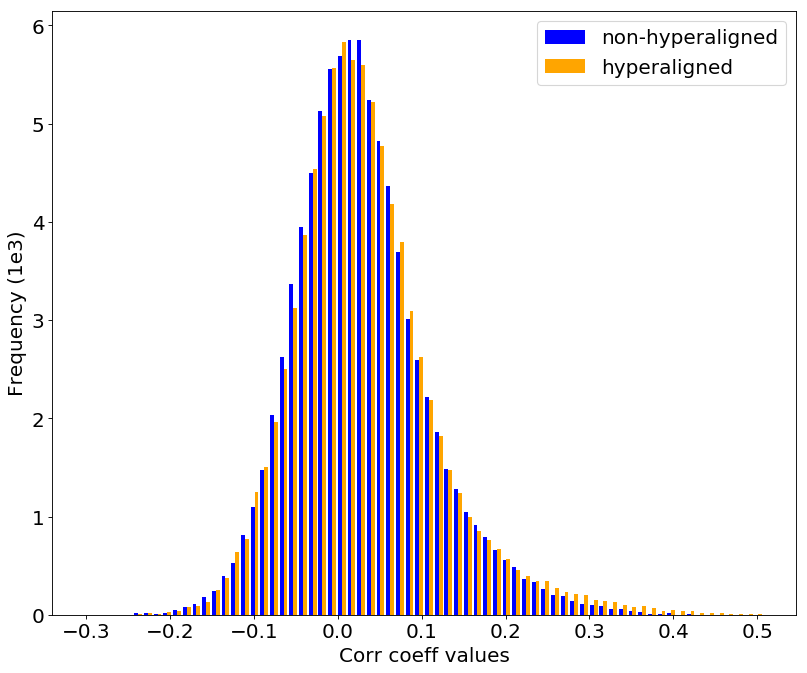



Chunk/run 5



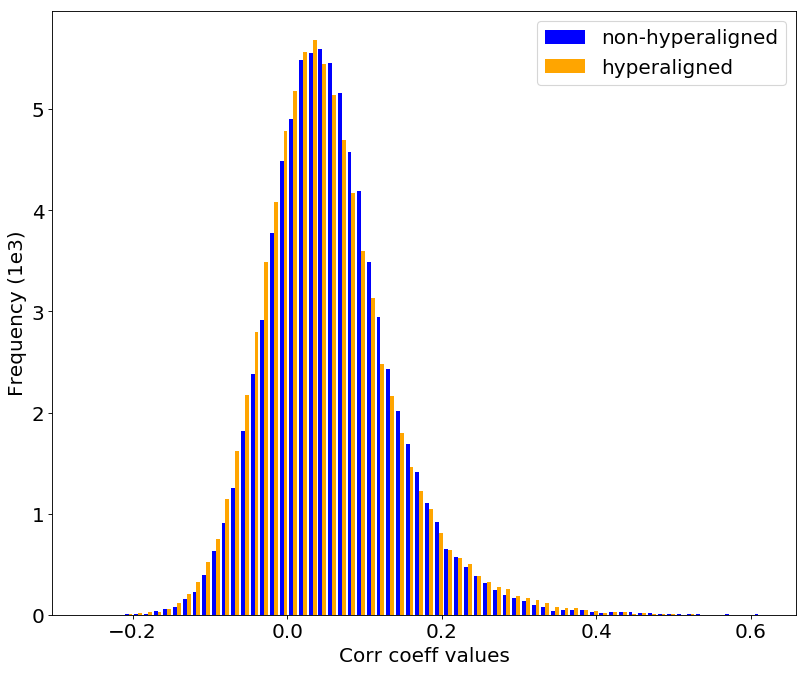



Chunk/run 6



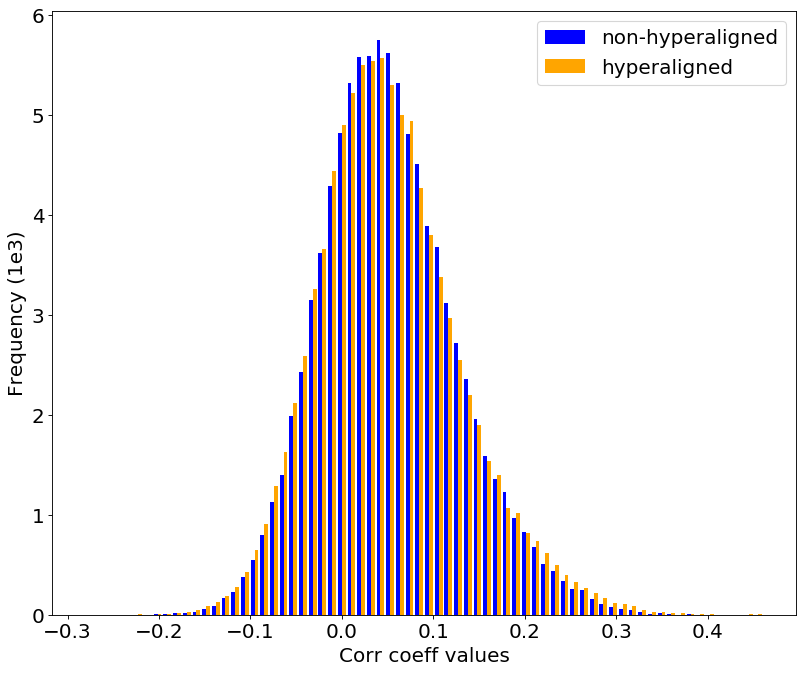



Chunk/run 7



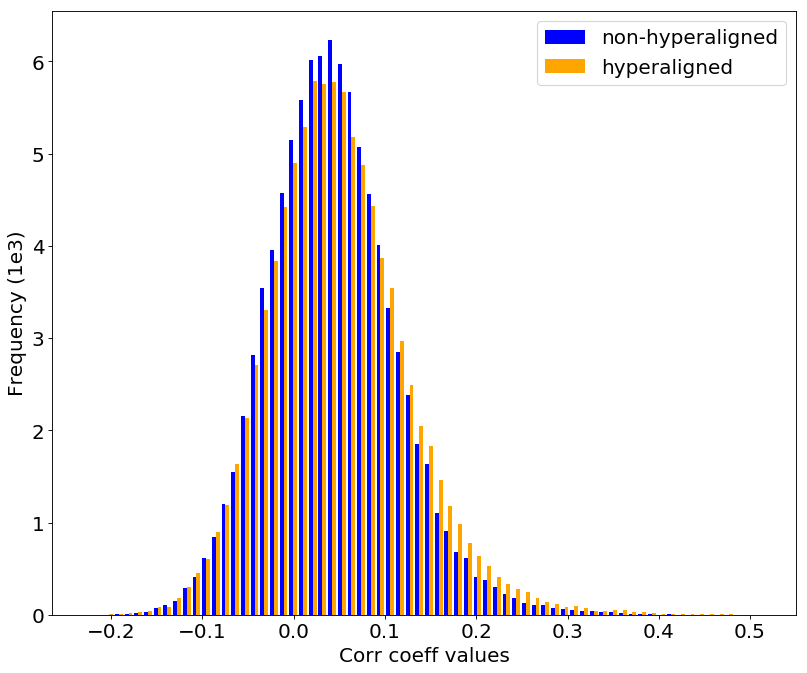



Chunk/run 8



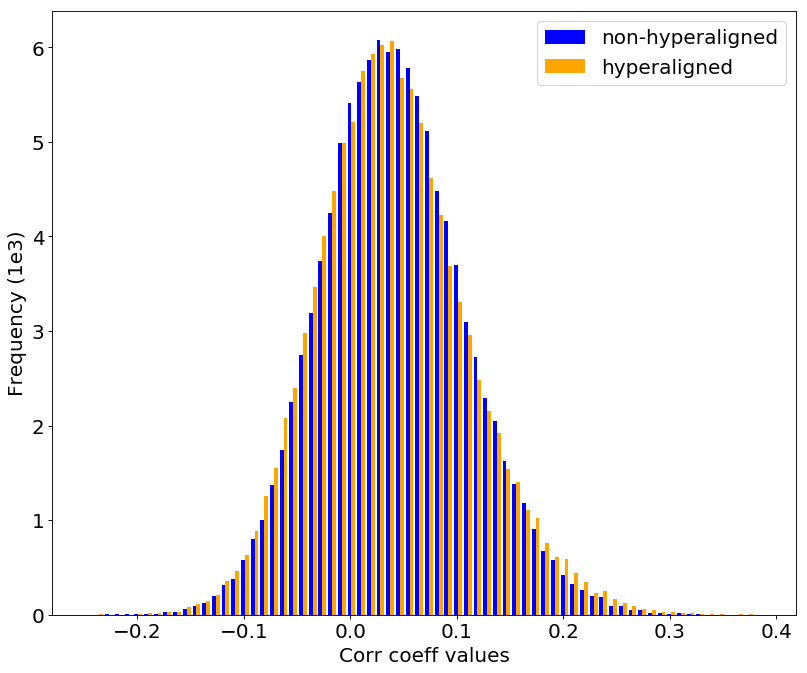



Chunk/run 9



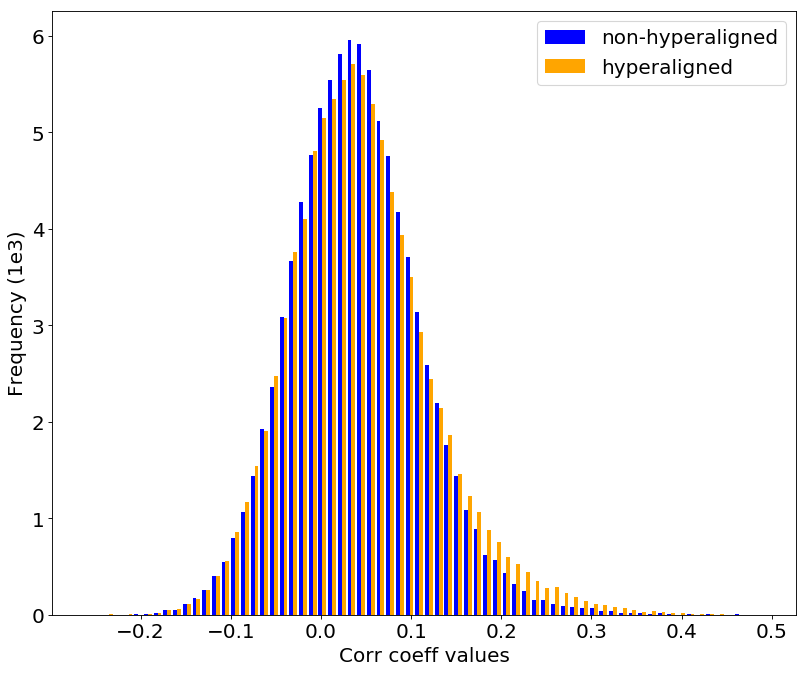

In [8]:
# Histograms of average corr coeffs both for non-hyperaligned and hyperaligned data

for chunk in range(chunkNo):
    
    print '\n\nChunk/run ' + str(chunk) + '\n'
    
    # size settings
    fig = pyplot.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
    rcParams.update({'font.size': 18})

    # histogram details
    colors = ['blue', 'orange']
    labels = ['non-hyperaligned', 'hyperaligned']
    nbins = 70

    pyplot.hist([meanCorr[chunk, :], meanCorrHyper[chunk, :]], 
                nbins, 
                density=True, 
                color=colors,
                label=labels)
    pyplot.xlabel('Corr coeff values')
    pyplot.ylabel('Frequency (1e3)')
    pyplot.legend(loc='best')
    pyplot.show()

<br>
<font size="4">

Well, it is variable. However, there is a general pattern: hyperalignment usually shifts voxels into the positive tail. We would need to examine the topography of the differences in more detail to be sure, but this is consistent with the idea that regions driven by the stimuli in the listening and reading tasks show larger ISC after hyperalignment.

</font>
<br><br>